In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import time
import itertools

%matplotlib inline

# Predict Future Sales

## 1. Load Data

In [2]:
df_train = pd.read_csv('./sales_train.csv')
df_test = pd.read_csv('./test.csv')
df_items = pd.read_csv('./items.csv')
df_item_categories = pd.read_csv('./item_categories_kor.csv')
df_shops = pd.read_csv('./shops.csv')

In [3]:
# null check
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


## 2. Preprocessing

### 중복 체크 - Shop name

In [4]:
# 0, 57 중복 / 1, 58 중복 -> train 데이터에서 동일 인덱스 처리
df_shops.iloc[[0,1,57,58]]

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
57,"Якутск Орджоникидзе, 56",57
58,"Якутск ТЦ ""Центральный""",58


### 이상치 제거

- item_cnt_day : 1000
- item_price : 30만

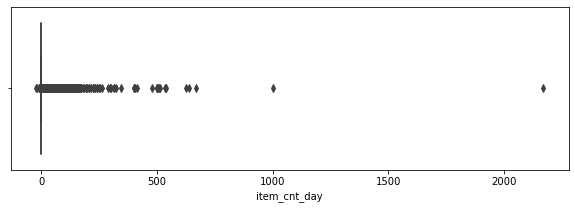

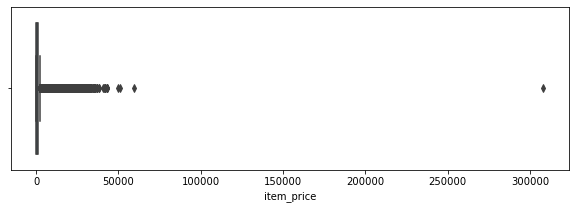

In [5]:
plt.figure(figsize=(10,3))
sns.boxplot(x='item_cnt_day', data=df_train)

plt.figure(figsize=(10,3))
sns.boxplot(x='item_price', data=df_train);

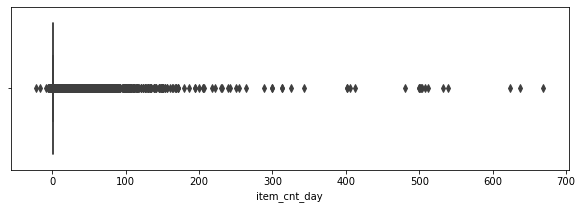

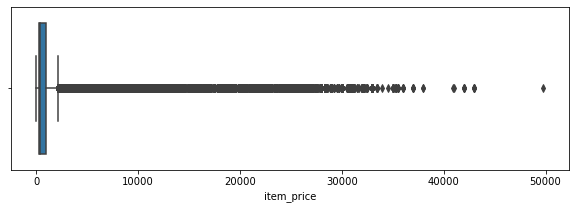

In [6]:
condition = (df_train.item_cnt_day < 1000)
df_train = df_train[condition]
df_train = df_train[df_train.item_price < 50000]

plt.figure(figsize=(10,3))
sns.boxplot(x='item_cnt_day', data=df_train)

plt.figure(figsize=(10,3))
sns.boxplot(x='item_price', data=df_train);

## 3. Create Feature

### 3.1 Matrix 생성

- test.csv의 shop 기준으로 Matrix 생성.
- date_block_num : 0~34 (예측월까지 병합)
- target인 item_cnt_day를 모델의 학습단위로 하는 월별 판매량으로 계산.

#### Matrix

In [7]:
matrix = []
cols = ['date_block_num', 'shop_id', 'item_id']
for i in range(34):
    sales = df_train[df_train['date_block_num'] == i]
    matrix.append(np.array(list(itertools.product([i], sales['shop_id'].unique(), sales['item_id'].unique())), dtype='int16'))
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)

# int8 -> Byte (-128 to 127), int16 -> Integer (-32768 to 32767)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols, inplace=True)

In [8]:
matrix.tail()

,date_block_num,shop_id,item_id
10768740,33,59,22162
10768930,33,59,22163
10769596,33,59,22164
10771122,33,59,22166
10770417,33,59,22167


#### Add Target

In [9]:
group = df_train.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)
group.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0


In [10]:
group.isna().sum()

date_block_num    0
shop_id           0
item_id           0
item_cnt_month    0
dtype: int64

In [11]:
matrix = pd.merge(matrix, group, how='left', on=['date_block_num','shop_id','item_id'])
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,19,NaN
1,0,0,27,NaN
2,0,0,28,NaN
3,0,0,29,NaN
4,0,0,32,6.0


In [65]:
matrix['item_cnt_month'] = (matrix['item_cnt_month'].fillna(0).clip(0, 20).astype(np.float16))

#### Merge : Matrix + test.csv

In [12]:
df_test['date_block_num'] = 34
df_test['date_block_num'] = df_test['date_block_num'].astype(np.int8)
df_test['shop_id'] = df_test['shop_id'].astype(np.int8)
df_test['item_id'] = df_test['item_id'].astype(np.int16)
df_test.drop(columns='ID', inplace=True)
df_test.head()

,shop_id,item_id,date_block_num
0,5,5037,34
1,5,5320,34
2,5,5233,34
3,5,5232,34
4,5,5268,34


In [13]:
matrix = pd.concat([matrix, df_test], axis=0, ignore_index=True)

In [14]:
matrix.to_csv('./matrix.csv', index=False)
matrix

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,19,NaN
1,0,0,27,NaN
2,0,0,28,NaN
3,0,0,29,NaN
4,0,0,32,6.0
...,...,...,...,...
11127951,34,45,18454,NaN
11127952,34,45,16188,NaN
11127953,34,45,15757,NaN
11127954,34,45,19648,NaN


### 3.2 Encoding

### shops

In [15]:
shp_city = ['야쿠츠크', '야쿠츠크', '아디게야', '발라시하', '볼츠스키',
           '볼로그다', '보로네슈', '보로네슈','보로네슈', '브로네슈',
           '쥬코브스키', '쥬코브스키', '온라인', '카잔', '카잔',
           '칼루가', '콜롬나', '크라스노야르스크', '크라스노야르스크', '쿠르스크',
           '모스크바', '모스크바', '모스크바', '모스크바', '모스크바',
           '모스크바', '모스크바', '모스크바', '모스크바', '모스크바',
           '모스크바', '모스크바', '모스크바', '미티시치', '니즈니노브고로드',
           '니즈니노브고로드', '노보시비르스크','노보시비르스크', '옴스크', '로스토프온돈',
           '로스토프온돈', '로스토프온돈', '상트페테르부르크', '상트페테르부르크', '사마라',
           '사마라', '세르기예프 포사트', '수르구트', '톰스크', '투먼',
           '투먼', '투먼', '우파', '우파', '힘키',
           '모스크바','체호프', '아쿠츠크', '아쿠츠크', '야로슬라블']
shp_type = ['기타', '쇼핑몰', '쇼핑몰', '쇼핑몰', '쇼핑몰',
           '쇼핑몰', '기타', '쇼핑몰', '쇼핑몰', '기타',
           '기타', '기타', '온라인몰', '쇼핑몰', '쇼핑몰',
           '쇼핑몰', '쇼핑몰', '쇼핑몰', '쇼핑몰', '쇼핑몰',
           '기타', '쇼핑몰', '쇼핑몰', '컴퓨터용품점', '컴퓨터용품점',
           '쇼핑몰', '쇼핑몰', '쇼핑몰', '쇼핑몰', '쇼핑몰',
           '쇼핑몰', '쇼핑몰', '쇼핑몰', '쇼핑몰', '쇼핑몰',
           '쇼핑몰', '쇼핑몰', '쇼핑몰', '쇼핑몰', '쇼핑몰',
           '쇼핑몰', '쇼핑몰', '쇼핑몰', '쇼핑몰', '쇼핑몰',
           '쇼핑몰', '쇼핑몰', '쇼핑몰', '쇼핑몰', '쇼핑몰',
           '쇼핑몰', '쇼핑몰', '쇼핑몰', '쇼핑몰', '쇼핑몰',
           '컴퓨터용품점', '쇼핑몰', '쇼핑몰', '쇼핑몰', '쇼핑몰']

In [16]:
le = LabelEncoder()
df_shops['city_id'] = le.fit_transform(shp_city)
df_shops['shop_type_id'] = le.fit_transform(shp_type)
df_shops.drop(columns='shop_name', inplace=True)
df_shops.head()

,shop_id,city_id,shop_type_id
0,0,17,0
1,1,17,1
2,2,14,1
3,3,5,1
4,4,8,1


#### Item Category

In [17]:
cat1, cat2 = [], []
for n in df_item_categories.item_category_name:
    
    _ = n.split('-')
    cat1.append(_[0].strip())
    try: 
        cat2.append(_[1].strip())
    except:
        cat2.append(np.nan)
        
cat1[-5:], cat2[-5:]

(['서비스', '서비스', '클린 미디어 (첨탑)', '클린 미디어 (조각)', '전원 요소'],
 [nan, '티켓', nan, nan, nan])

In [18]:
le = LabelEncoder()
df_item_categories['type_code'] = le.fit_transform(cat1)
df_item_categories['subtype_code'] = le.fit_transform(cat2)

In [19]:
df_item_categories.drop(columns='item_category_name', inplace=True)
df_item_categories.head()

,item_category_id,type_code,subtype_code
0,0,0,61
1,1,10,6
2,2,10,7
3,3,10,8
4,4,10,10


### Items

In [20]:
# item_id로 인코딩 대체
df_items.drop(columns='item_name', inplace=True)
df_items.head()

,item_id,item_category_id
0,0,40
1,1,76
2,2,40
3,3,40
4,4,40


### Matrix에 병합

In [22]:
matrix = pd.read_csv('./matrix.csv')
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,19,NaN
1,0,0,27,NaN
2,0,0,28,NaN
3,0,0,29,NaN
4,0,0,32,6.0


In [23]:
matrix = pd.merge(matrix, df_shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, df_items, on=['item_id'], how='left')
matrix = pd.merge(matrix, df_item_categories, on=['item_category_id'], how='left')
matrix['city_id'] = matrix['city_id'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)

#### Shop 중복처리 적용

In [24]:
matrix.loc[matrix.shop_id == 0, 'shop_id'] = 57
matrix.loc[matrix.shop_id == 1, 'shop_id'] = 58

matrix.shop_id.unique()

array([57, 58,  2,  3,  4,  6,  7,  8, 10, 12, 13, 14, 15, 16, 18, 19, 21,
       22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 35, 37, 38, 41, 42, 43,
       44, 45, 46, 47, 50, 51, 52, 53, 54, 56, 59,  5, 55, 17,  9, 49, 39,
       40, 48, 34, 33, 20, 11, 36], dtype=int64)

In [25]:
matrix

,date_block_num,shop_id,item_id,item_cnt_month,city_id,shop_type_id,item_category_id,type_code,subtype_code
0,0,57,19,NaN,17,0,40,8,3
1,0,57,27,NaN,17,0,19,2,7
2,0,57,28,NaN,17,0,30,1,13
3,0,57,29,NaN,17,0,23,2,15
4,0,57,32,6.0,17,0,40,8,3
...,...,...,...,...,...,...,...,...,...
11127951,34,45,18454,NaN,10,1,55,11,57
11127952,34,45,16188,NaN,10,1,64,7,38
11127953,34,45,15757,NaN,10,1,55,11,57
11127954,34,45,19648,NaN,10,1,40,8,3


### 3.3 수치데이터 생성(price, cnt, mean, lag 등)

1. 판매량 관련
    - date_block_num
    - date_block_num, item_id
    - date_block_num, shop_id
    - date_block_num, item_category_id
    - date_block_num, shop_id, item_category_id
    - date_block_num, shop_id, type_code
    - date_block_num, shop_id, subtype_code
    - date_block_num, city_id
    - date_block_num, city_id, item_id
    - date_block_num, type_code
    - date_block_num, subtype_code
2. 트렌드 관련
    - date_block_num, item_id (price)
    - date_block_num, shop_id (revenue)
3. 기타
    - 시간 관련(월,일)
    - 전국매장운영현황
    - 러시아 CPI(소비자물가지수)

In [26]:
def lag_feature(df, lag, col):
    temp = df[['date_block_num', 'shop_id', 'item_id', col]]
    
    for i in lag:
        shift = temp.copy()
        shift.date_block_num += i
        shift.columns = ['date_block_num', 'shop_id', 'item_id', col+'_lag_'+str(i)]
        df = pd.merge(df, shift, how='left', on=['date_block_num','shop_id','item_id'])
    return df

In [27]:
####################해석######################
def select_trend(row):
    for lag in lags:
        if row['delta_price_lag_'+str(lag)]:
            return row['delta_price_lag_'+str(lag)]
    return 0

#### 판매량 관련

In [28]:
# date_block_num
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_avg_item_cnt')
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)

In [29]:
# date_block_num, item_id
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_item_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)

In [30]:
# date_block_num, shop_id
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)

In [31]:
# date_block_num, item_category_id
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_cat_avg_item_cnt')
matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)

In [32]:
# date_block_num, shop_id, item_category_id
group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)

In [33]:
# date_block_num, shop_id, type_code
group = matrix.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_type_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'type_code'], how='left')
matrix['date_shop_type_avg_item_cnt'] = matrix['date_shop_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_type_avg_item_cnt')
matrix.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)

In [34]:
# date_block_num, shop_id, subtype_code
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
matrix['date_shop_subtype_avg_item_cnt'] = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_subtype_avg_item_cnt')
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)

In [35]:
# date_block_num, city_id
group = matrix.groupby(['date_block_num', 'city_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'city_id'], how='left')
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_city_avg_item_cnt')
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)

In [36]:
# date_block_num, city_id, item_id
group = matrix.groupby(['date_block_num', 'item_id', 'city_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'city_id'], how='left')
matrix['date_item_city_avg_item_cnt'] = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_item_city_avg_item_cnt')
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)

In [37]:
# date_block_num, type_code
group = matrix.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_type_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'type_code'], how='left')
matrix['date_type_avg_item_cnt'] = matrix['date_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_type_avg_item_cnt')
matrix.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)

In [38]:
# date_block_num, subtype_code
group = matrix.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_subtype_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'subtype_code'], how='left')
matrix['date_subtype_avg_item_cnt'] = matrix['date_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_subtype_avg_item_cnt')
matrix.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)

#### 트렌드 관련

- 상품 가격변동

In [39]:
# 전월평균 계산
group = df_train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

In [40]:
# 월별평균 계산
group = df_train.groupby(['date_block_num', 'item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

In [41]:
# 전월평균 대비 월별평균 백분율 계산(평균대비 변동량)
lags = [1, 2, 3, 4, 5, 6]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')
for lag in lags:
    matrix['delta_price_lag_'+str(lag)] = \
    (matrix['date_item_avg_item_price_lag_'+str(lag)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']

In [42]:
matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

In [43]:
features_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    features_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    features_to_drop += ['delta_price_lag_'+str(i)]

In [44]:
matrix.drop(features_to_drop, axis=1, inplace=True)

- 매장 매출액 변동

In [45]:
# 판매액 계산
df_train['revenue'] = df_train.item_price * df_train.item_cnt_day
df_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue
0,02.01.2013,0,59,22154,999.00,1.0,999.00
1,03.01.2013,0,25,2552,899.00,1.0,899.00
2,05.01.2013,0,25,2552,899.00,-1.0,-899.00
3,06.01.2013,0,25,2554,1709.05,1.0,1709.05
4,15.01.2013,0,25,2555,1099.00,1.0,1099.00


In [46]:
# 전월평균 계산
group = df_train.groupby(['date_block_num', 'shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

In [47]:
# 월별평균 계산
group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

In [48]:
# 전월평균 대비 월별평균 백분율 계산(평균대비 변동량)
matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

In [49]:
matrix = lag_feature(matrix, [1], 'delta_revenue')

In [50]:
matrix.drop(['date_shop_revenue', 'shop_avg_revenue', 'delta_revenue'], axis=1, inplace=True)

#### 기타

- 시간

In [51]:
matrix['month'] = matrix['date_block_num'] % 12

In [52]:
days = pd.Series([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)

- cpi

In [53]:
cpi = pd.read_csv('./cpi.csv', encoding='cp949')
temp = cpi[['date_blcok_num', '발표']]
temp.columns = ['date_block_num', 'cpi']
temp['cpi'] = list(map(lambda x: x.replace('%',''),temp['cpi']))
temp.cpi = temp.cpi.astype(np.float64)
temp.tail()

C:\Users\rkdtk\AppData\Local\Temp/ipykernel_16936/2690695626.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['cpi'] = list(map(lambda x: x.replace('%',''),temp['cpi']))
C:\Users\rkdtk\anaconda3\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,date_block_num,cpi
29,29,15.3
30,30,15.6
31,31,15.8
32,32,15.7
33,33,15.6


In [54]:
matrix = pd.merge(matrix, temp, how='left', on='date_block_num')
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_id,shop_type_id,item_category_id,type_code,subtype_code,date_avg_item_cnt_lag_1,...,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1,month,days,cpi
0,0,57,19,NaN,17,0,40,8,3,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,31,7.1
1,0,57,27,NaN,17,0,19,2,7,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,31,7.1
2,0,57,28,NaN,17,0,30,1,13,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,31,7.1
3,0,57,29,NaN,17,0,23,2,15,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,31,7.1
4,0,57,32,6.0,17,0,40,8,3,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,31,7.1


- 매장운영현황

In [55]:
shp = pd.read_csv('./shop_count.csv')
shp.columns = ['date_block_num', 'shp_cnt', 'open_shp_mth', 'close_shp_mth']
shp.head()

,date_block_num,shp_cnt,open_shp_mth,close_shp_mth
0,0,45,0,0
1,1,46,1,0
2,2,46,2,2
3,3,45,0,1
4,4,45,1,1


In [56]:
matrix = pd.merge(matrix, shp, how='left', on='date_block_num')

In [57]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_id,shop_type_id,item_category_id,type_code,subtype_code,date_avg_item_cnt_lag_1,...,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1,month,days,cpi,shp_cnt,open_shp_mth,close_shp_mth
0,0,57,19,NaN,17,0,40,8,3,NaN,...,NaN,NaN,0.0,NaN,0,31,7.1,45.0,0.0,0.0
1,0,57,27,NaN,17,0,19,2,7,NaN,...,NaN,NaN,0.0,NaN,0,31,7.1,45.0,0.0,0.0
2,0,57,28,NaN,17,0,30,1,13,NaN,...,NaN,NaN,0.0,NaN,0,31,7.1,45.0,0.0,0.0
3,0,57,29,NaN,17,0,23,2,15,NaN,...,NaN,NaN,0.0,NaN,0,31,7.1,45.0,0.0,0.0
4,0,57,32,6.0,17,0,40,8,3,NaN,...,NaN,NaN,0.0,NaN,0,31,7.1,45.0,0.0,0.0


## 4. EDA

In [58]:
# fillna
temp = matrix[ (matrix.date_block_num > 11) & (matrix.date_block_num < 34)]
#temp.fillna(inplace=True)
temp.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_id,shop_type_id,item_category_id,type_code,subtype_code,date_avg_item_cnt_lag_1,...,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1,month,days,cpi,shp_cnt,open_shp_mth,close_shp_mth
4488710,12,2,27,NaN,14,1,19,2,7,2.765625,...,3.525391,3.646484,-0.282715,1.211914,0,31,6.1,47.0,0.0,0.0
4488711,12,2,30,NaN,14,1,40,8,3,2.765625,...,2.125000,2.226562,-0.483398,1.211914,0,31,6.1,47.0,0.0,0.0
4488712,12,2,31,NaN,14,1,37,20,41,2.765625,...,1.635742,1.635742,-0.137451,1.211914,0,31,6.1,47.0,0.0,0.0
4488713,12,2,32,1.0,14,1,40,8,3,2.765625,...,2.125000,2.226562,-0.407227,1.211914,0,31,6.1,47.0,0.0,0.0
4488714,12,2,33,1.0,14,1,37,20,41,2.765625,...,1.635742,1.635742,-0.225464,1.211914,0,31,6.1,47.0,0.0,0.0


In [59]:
temp.shape, temp.isna().sum()

((6425046, 36),
 date_block_num                                0
 shop_id                                       0
 item_id                                       0
 item_cnt_month                          5503648
 city_id                                       0
 shop_type_id                                  0
 item_category_id                              0
 type_code                                     0
 subtype_code                                  0
 date_avg_item_cnt_lag_1                 1360768
 date_item_avg_item_cnt_lag_1            1360768
 date_item_avg_item_cnt_lag_2            1548792
 date_item_avg_item_cnt_lag_3            1744585
 date_item_avg_item_cnt_lag_6            2300337
 date_item_avg_item_cnt_lag_12           3389959
 date_shop_avg_item_cnt_lag_1            1360768
 date_shop_avg_item_cnt_lag_2            1548792
 date_shop_avg_item_cnt_lag_3            1744585
 date_shop_avg_item_cnt_lag_6            2300337
 date_shop_avg_item_cnt_lag_12           3389959
 dat